In [2]:
import cv2
import torch
import segment_anything
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import gzip
from utils import *
from dataset import BTCV2DSliceDataset, to_uint8_rgb, remove_pure_background
from torch.utils.data import DataLoader
from prompt_gen import *
import nibabel as nib
import json

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [4]:
sam = sam_model_registry['default']('./sam_vit_h_4b8939.pth')
sam.to(device)
predictor = SamPredictor(sam)

# Test SAM on single image

In [7]:
image = cv2.imread('./images/Dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
image.shape

(1365, 2048, 3)

In [9]:
predictor.set_image(image)

In [10]:
input_point = np.array([[1200, 800], [1000,700]])
input_label = np.array([1, 1])

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label,
    multimask_output=True,
)

In [12]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

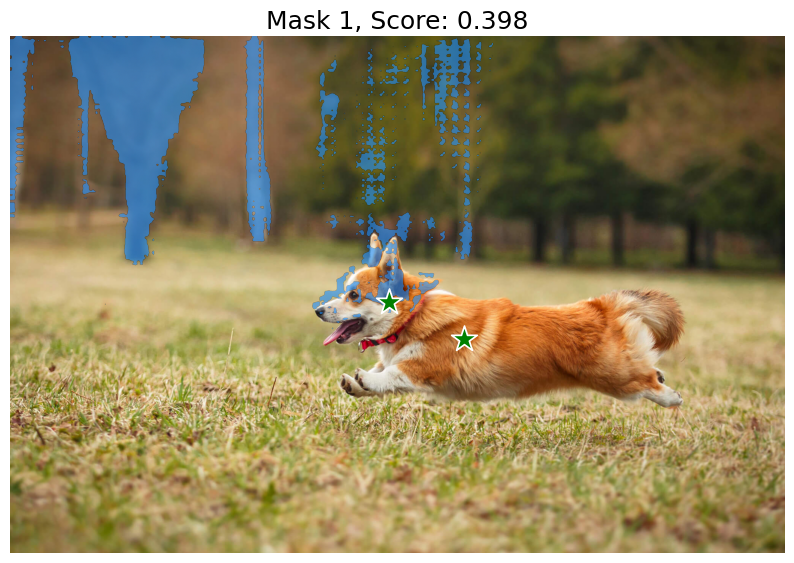

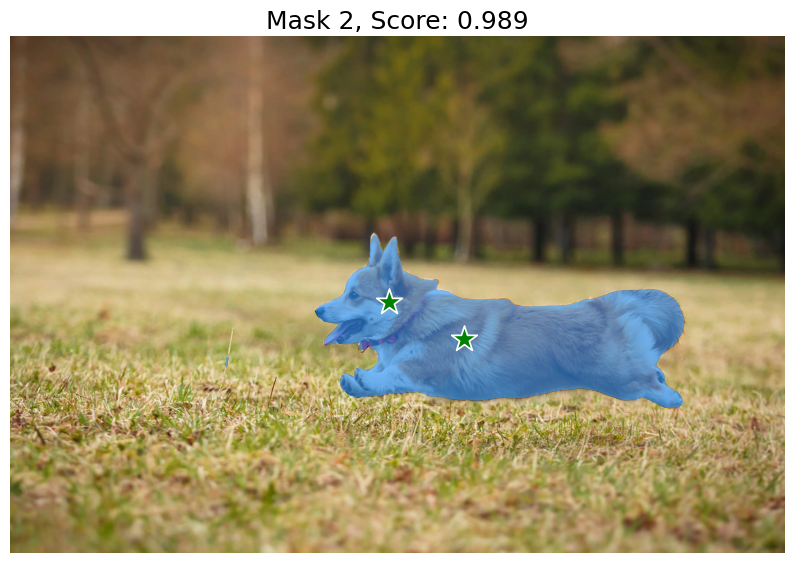

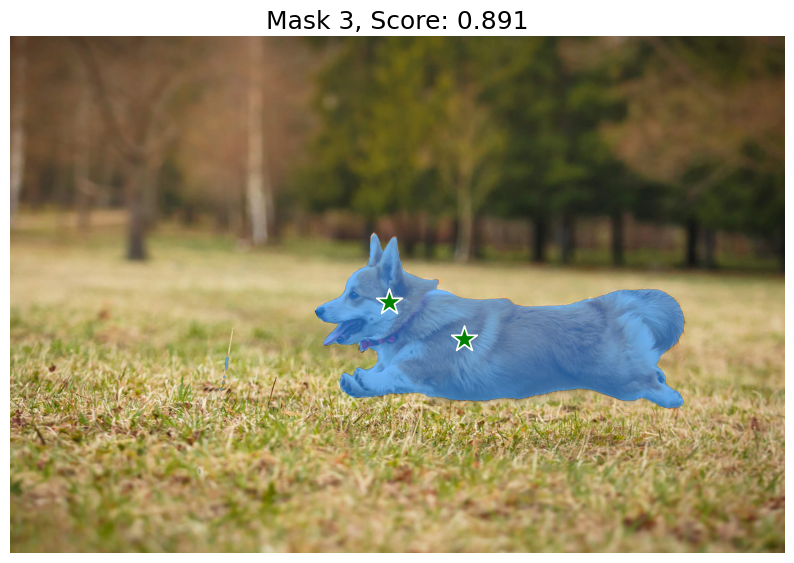

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [14]:
input_box = np.array([750, 450, 1800, 1000])

masks, _, _ = predictor.predict(box = input_box[None, :])

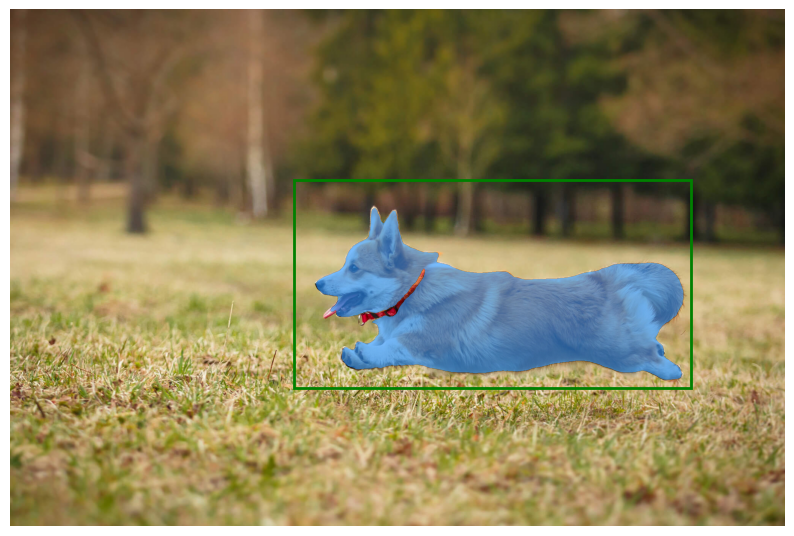

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

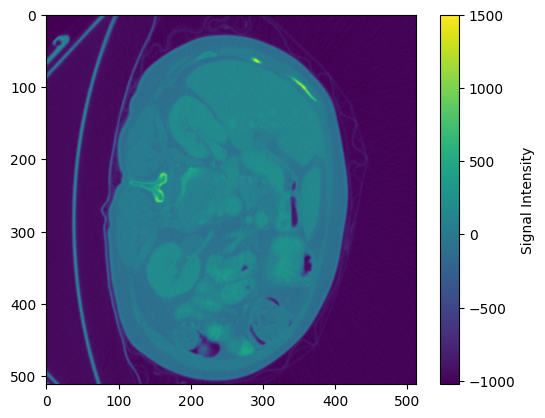

In [16]:
img = nib.load('./data/imagesTr/img0001.nii.gz').get_fdata()

plt.imshow(img[:, :, 100])
plt.colorbar(label='Signal Intensity')

# Test box prompt generation

In [5]:
preprocess = lambda images, labels: to_uint8_rgb(*remove_pure_background(images, labels))

train_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='training', 
                               preprocess=preprocess)
validation_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='validation', 
                               preprocess=preprocess)

In [22]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [23]:
len(validation_loader)

408

In [24]:
batch = next(iter(validation_loader))
boxes = box_prompt(batch['label'], device=device)

In [25]:
boxes

[{9: tensor([274, 236, 291, 264], device='mps:0')}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


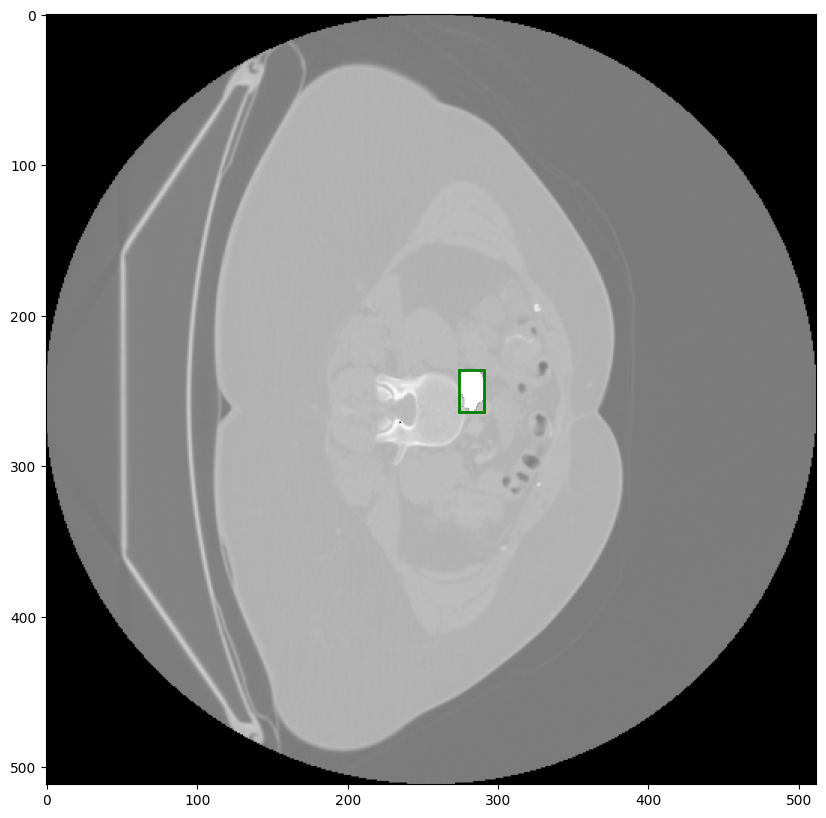

In [26]:
img = batch['image']

for i in range(img.shape[0]):
    plt.figure(figsize=(10,10))
    plt.imshow(img[i])

    show_mask(batch['label'][i], plt.gca())

    bbox = boxes[i]

    for k, b in bbox.items():
        show_box(b.cpu().numpy(), plt.gca())

# Test box input for validation dataset

In [18]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [7]:
from segment_anything.utils.transforms import ResizeLongestSide

def prepare_image(image, transform, device):
    #print(image.shape)
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()


def batched_input_gen(images, prompts, types, sam):
    """
    参数：
    images:  torch.Tensor [B, H, W, 3] 
    prompts: list of dictionaries of length B
             for box prompts: organ_id -> torch.Tensor[xmin, ymin, xmax, ymax]
             for single point prompts:
             for multipoint prompts:  
    types:   list of strings indicating prompt types 
             each string can be 'box' or 'point'
    返回：
    batched_input: list of dictionaries with keys 
             'image', 'original size', 'point_coords', 'point_labels', 'boxes'
    """
    batch_size = images.shape[0]
    batched_input = []
    resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

    for img_idx in range(batch_size):
        input = {'image' : prepare_image(images[img_idx].numpy(), resize_transform, sam.device), 
                 'original_size' : images.shape[1:3]}

        if types[img_idx] == 'box':
            bboxes = prompts[img_idx] # dict of organ_id -> bbox 
            input['boxes'] = resize_transform.apply_boxes_torch(torch.vstack(list(bboxes.values())), 
                                                                                 input['original_size'])
        else:
            # point prompt not implemented
            raise NotImplementedError

        
        batched_input.append(input)
    
    return batched_input

In [30]:
import tqdm

total_intersection = dict()  # organ_id -> total intersect pixels
total_mask_pixels = dict()   # organ_id -> total mask pixels

# Dice = 2 * intersect / total mask pixels 
# mDice = Average Dice over all categories

for batched_data in tqdm.tqdm(validation_loader):
    images, labels = batched_data['image'], batched_data['label'] # labels transferred to mps will cause strange errors
    batch_size = images.shape[0]
    bboxes = box_prompt(labels, device=device)
    batched_input = batched_input_gen(images, bboxes, ['box'] * batch_size, sam)
    batched_output = sam(batched_input, multimask_output=False)

    for img_idx in range(batch_size):
        # for every input image
        output = batched_output[img_idx]
        for box_idx, gt_label in enumerate(bboxes[img_idx].keys()):
            # for every bounding box in the image
            gt_mask = (labels[img_idx] == gt_label).cpu()
            pred_mask = output['masks'][box_idx].cpu()

            intersection = torch.sum(torch.logical_and(gt_mask ,pred_mask)).item()
            total_pixels = torch.sum(gt_mask).item() + torch.sum(pred_mask).item()

            total_intersection.setdefault(gt_label, 0)
            total_mask_pixels.setdefault(gt_label, 0)

            total_intersection[gt_label] += intersection
            total_mask_pixels[gt_label] += total_pixels 

dice = dict([(organ_id , 2 * total_intersection[organ_id] / total_mask_pixels[organ_id]) for organ_id in total_intersection])
mDice = np.mean(list(dice.values()))

100%|██████████| 408/408 [33:41<00:00,  4.96s/it]


In [31]:
mDice

0.7584724670827128

In [32]:
dice

{9: 0.9025318571667373,
 8: 0.8308245679807033,
 6: 0.8565980021071065,
 2: 0.9303768496799304,
 3: 0.9340228087842971,
 1: 0.9089565733062422,
 11: 0.6832838405333894,
 7: 0.7833670571452539,
 13: 0.7377525650453479,
 10: 0.26171577829533443,
 12: 0.6397041614005523,
 5: 0.8175510164248002,
 4: 0.5734569942055717}

In [21]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=True)
iter_loader = iter(validation_loader)

visualize some of the predictions

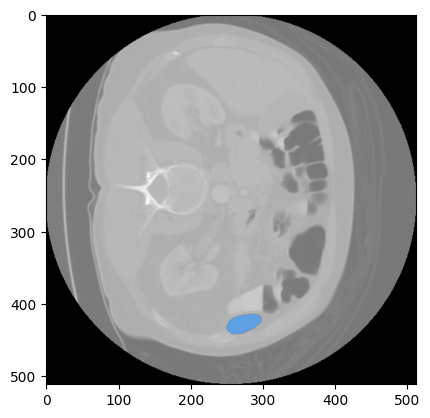

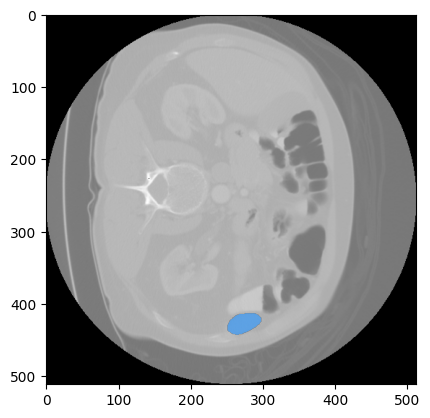

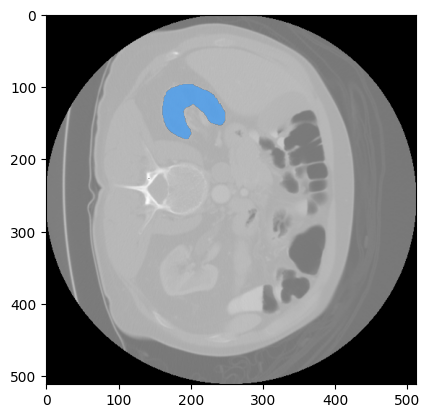

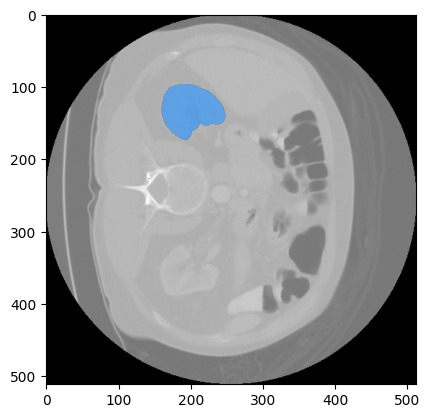

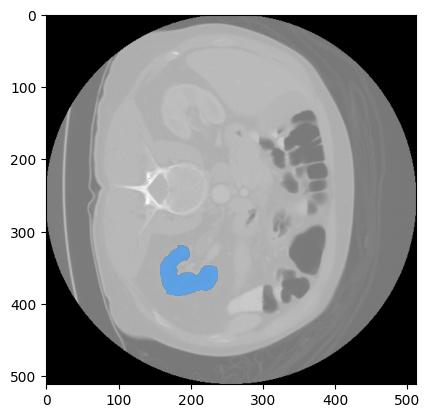

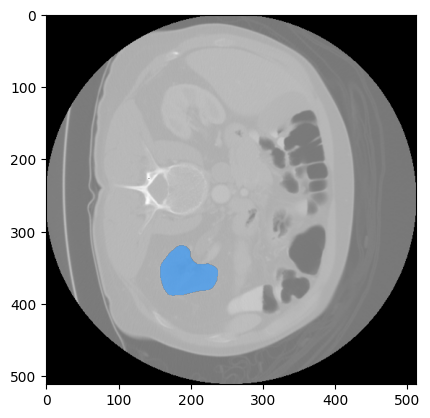

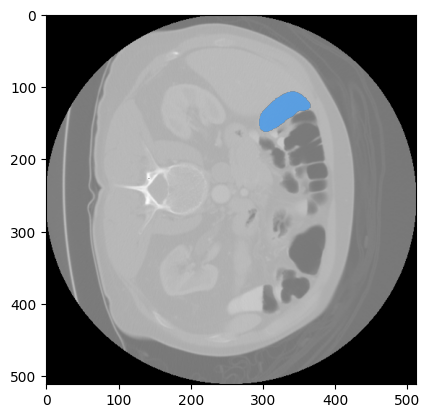

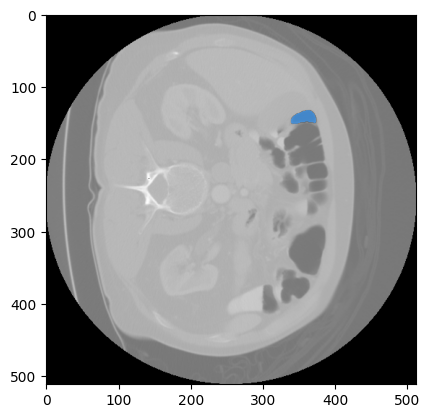

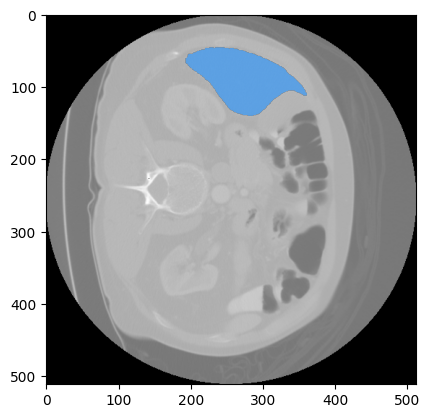

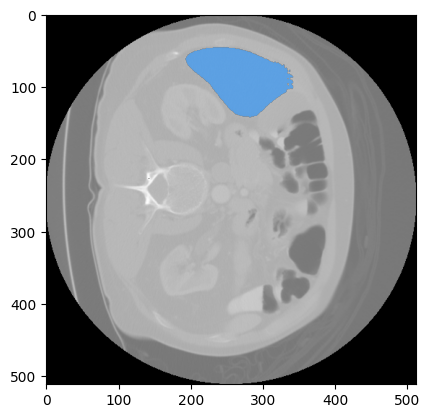

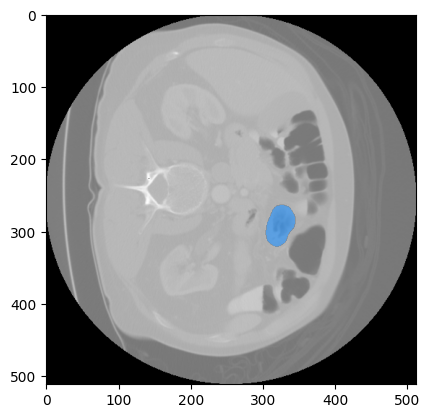

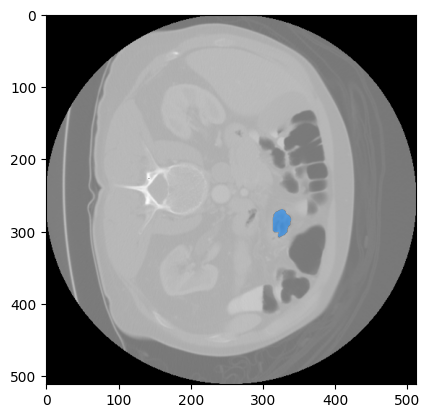

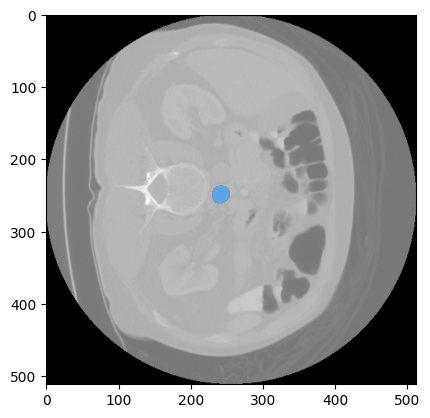

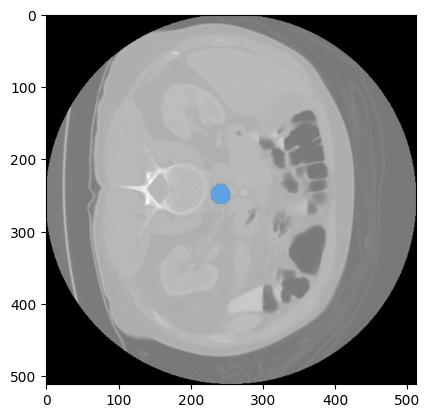

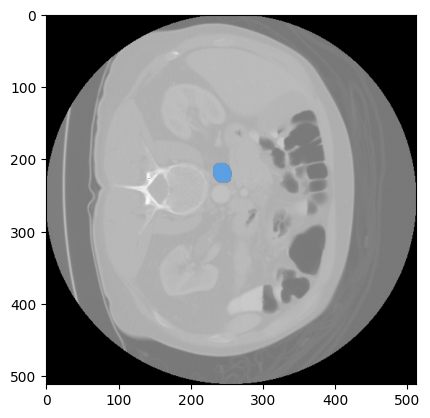

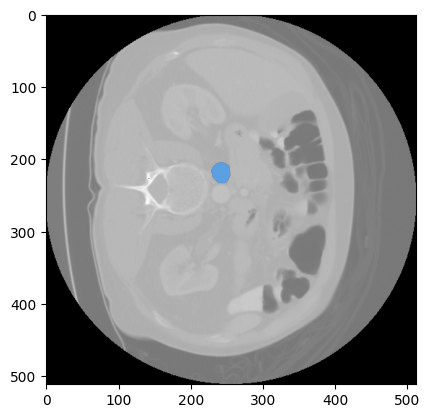

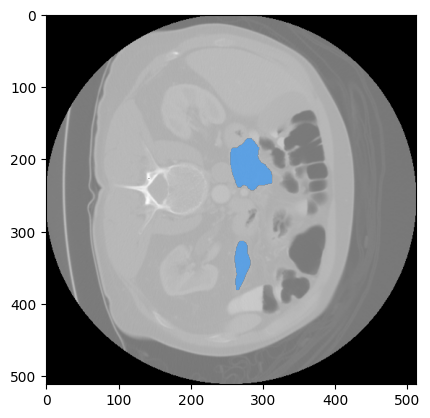

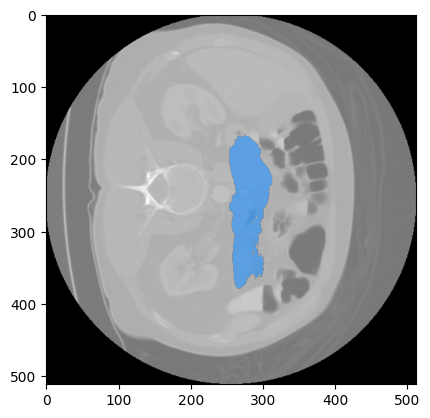

In [22]:
batched_data = next(iter_loader)

images, labels = batched_data['image'], batched_data['label'] # labels transferred to mps will cause strange errors
batch_size = images.shape[0]
bboxes = box_prompt(labels, device=device)
batched_input = batched_input_gen(images, bboxes, ['box'] * batch_size, sam)
batched_output = sam(batched_input, multimask_output=False)

for img_idx in range(batch_size):
    # for every input image
    output = batched_output[img_idx]
    for box_idx, gt_label in enumerate(bboxes[img_idx].keys()):
        # for every bounding box in the image
        gt_mask = (labels[img_idx] == gt_label).cpu().numpy()
        pred_mask = output['masks'][box_idx].cpu().numpy()

        plt.figure()
        plt.imshow(images[img_idx])
        show_mask(gt_mask, plt.gca())
        plt.show()
        plt.figure()
        plt.imshow(images[img_idx])
        show_mask(pred_mask[0], plt.gca())
        plt.show()

# Fine-tuning model on BTCV Dataset